### Student Information
Name: 林哲兆 (NTPU)

Student ID: 711233103

GitHub ID: JoshLin1112

Kaggle name: josh4102

Kaggle private scoreboard snapshot:

![](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

---
### Table of Contents

1. Data preparation   
   
2. Data pre-processing ( for Transformer model )   
   
3. Transformer model training
    - 3.1 BERT

    - 3.2 RoBERTa

4. Transformer model prediction
    - 4.1 BERT

    - 4.2 RoBERTa
5. Data pre-processing ( for fasttext, word2vec model )

6. Fasttext model training and prediction

7. Word2vec pre-trained model prediction with different classifier 
    - 8.1 Logistic Regression Classifier  
       
    - 8.2 XGBoost Classifier  

8. Conclusion

---
### Part.1 - Data preparation

In [4]:
import pandas as pd

# read the data
tweets_raw = pd.read_json("kaggle-inclass/tweets_DM.json", lines=True)
identification = pd.read_csv('kaggle-inclass/data_identification.csv')
emotion = pd.read_csv('kaggle-inclass/emotion.csv')
tweets_raw

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets
...,...,...,...,...,...
1867530,827,hashtag_tweets,"{'tweet': {'hashtags': ['mixedfeeling', 'butim...",2015-05-12 12:51:52,tweets
1867531,368,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x29d0...",2017-10-02 17:54:04,tweets
1867532,498,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2a6a...",2016-10-10 11:04:32,tweets
1867533,840,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x24fa...",2016-09-02 14:25:06,tweets


In [5]:
# separate the values in '_source' column
tweets_raw = tweets_raw.join(pd.json_normalize(tweets_raw['_source']))

# drop unnecessary columns and rename columns
tweets_raw = tweets_raw.drop(columns=['_source', '_index', '_score', '_crawldate', '_type']) 
tweets_raw = tweets_raw.rename(columns={'tweet.hashtags': 'hashtags', 'tweet.tweet_id': 'tweet_id', 'tweet.text': 'text'})
tweets_raw = tweets_raw[['tweet_id', 'hashtags', 'text']]

In [6]:
# merge the identification and emotion datasets
tweets_train_test = tweets_raw.merge(identification, how='left', on='tweet_id')
tweets_df = tweets_train_test.merge(emotion, how='left', on='tweet_id')
tweets_df.head()

,tweet_id,hashtags,text,identification,emotion
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k...",test,NaN
3,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
4,0x2de201,[],"""Trust is not the same as faith. A friend is s...",test,NaN


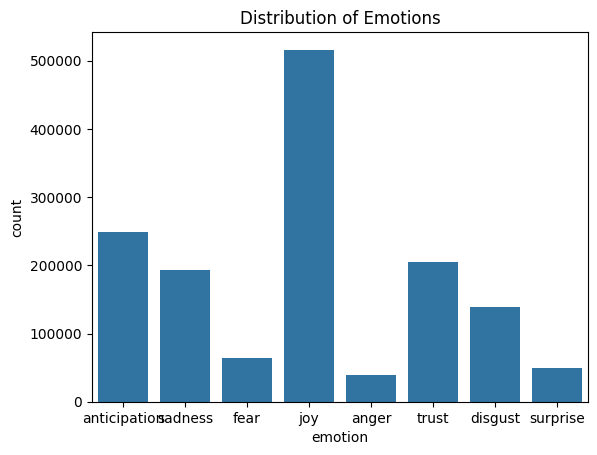

In [13]:
# plot valus of emotion
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='emotion', data=tweets_df)
plt.title('Distribution of Emotions')
plt.show()

# We can found that the distribution of emotions is not balanced
# Texts belong to 'joy' is much more than other categories.

In [9]:
tweets_df.to_csv('kaggle-inclass/df_tweets.csv', index=False)

---
### Part.2 - Data preprocessing

Tweet corpora are informal and often contain non-standard language, such as @-mentions for tagging users. These non-essential symbols should be removed during pre-processing to ensure accurate analysis. Other example of non-essential symbols:   
1. URL
2. #(Hashtag)
3. repeat alphabets
4. some unknown tokens in text

In [2]:
import pandas as pd
# tweets_df = pd.read_csv('kaggle-inclass/df_tweets.csv')
tweets_df = pd.read_csv('df_tweets.csv')

In [3]:
import re

def clean_text(text):
    # remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # remove @
    text = re.sub(r'@\w+', '', text)
    # remove hashtag sign'#'
    text = re.sub(r'#', '', text)
    # deal with the repeat alphabets , "soooo happy" -> "so happy"
    text = re.sub(r'(.)\1+', r'\1', text)
    # remove unknown term '<LH>, lh'
    text = re.sub('<LH>','', text)
    text = re.sub('lh','', text)
    # lower the text and remoce space
    text = text.lower()
    text = text.strip()
    return text

tweets_df['text'] = tweets_df['text'].apply(clean_text)

Tweet corpora often contain emojis, which need to be ``demojified`` or replaced with their corresponding text to ensure accurate text analysis.

In [4]:
import emoji
from emoji_translate.emoji_translate import Translator

# translator of emojis
emo = Translator(exact_match_only=False, randomize=True)

# bulid a dictionary of all emojis
# note that we need to add a space before and after each emoji, prevent the situations like "👍👍👍" -> "thumbthumbthumb"
all_emojis = [char for char in emoji.EMOJI_DATA]
replace_dict = {emoji_char: ' ' + emo.demojify(emoji_char).strip(':') + ' ' 
                for emoji_char in all_emojis}

def demojify_unique(text):

    # emoji mapping
    for emoji_char, replacement in replace_dict.items():
        text = text.replace(emoji_char, replacement)
    # remove extra spaces
    result = ' '.join(text.split())
    # remove duplicate words , e.g. "hello hello" -> "hello"
    result = re.sub(r'\b(\w+)( \1)+\b', r'\1', result)
    return result

tweets_df['text'] = tweets_df['text'].apply(demojify_unique)

In [4]:
tweets_df.sample(5)[['text', 'emotion']].iloc[0]['text']

'i honestly have no luck picking coupons, ned to give up i think.'

---
### Part. 3 Transformer model training

##### From the beginnig, I chose ``BERT`` as the training model for several reasons. First, ``BERT`` is a newer technique in Natural Language Processing compared to ``BOW`` or ``Word2vec``. This suggests it has the potential for superior performance on the task. Additionally, BERT's hardware requirements are still within the capabilities of my computer. Considering both factors, ``BERT`` appears to be the most suitable choice for my needs.

In [5]:
tweets_train = tweets_df[tweets_df['identification'] == 'train']
tweets_test = tweets_df[tweets_df['identification'] == 'test']
print(len(tweets_train) + len(tweets_test))

1867535


In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch

c:\Users\User\Miniconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


When we'll train a BERT model or other NN models by Pytorch, we should define a ``Dataset`` class first to load our data and tokenize the texts. And I create two kind of dataset to try some diffirent input.  
- TweetDataset treat both text and hashtag as input.
- NoHashtagTweetDataset only use text as input.

In [ ]:
# load model from huggingface
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=8)  

# create dataset
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, texts, hashtags, labels):
        self.texts = texts
        self.hashtags = hashtags
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # combine text and hashtag, and add [SEP] between them
        text = self.texts[idx] + " [SEP] " + self.hashtags[idx]
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128)
        
        # covert to tensor
        item = {key: torch.tensor(val) for key, val in inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# We need to encode the emotions to vector
labels = ["joy", "anticipation", "trust", "sadness", "disgust", "fear", "surprise", "anger"] 
label_encoder = LabelEncoder()
train_emotion_label = tweets_train['emotion'].tolist()
train_encoded_labels = label_encoder.fit_transform(train_emotion_label)


# extract data
train_texts = tweets_train['text'].tolist()  # text list
train_hashtags = tweets_train['hashtags'].tolist()  # hashtag list 

# create dataset
train_dataset = TweetDataset(train_texts, train_hashtags, train_encoded_labels)

c:\Users\User\Miniconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\Miniconda3\envs\myenv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# create dataset
class NoHashtagTweetDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # combine text and hashtag, and add [SEP] between them
        text = self.texts[idx]
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128)
        
        # covert to tensor
        item = {key: torch.tensor(val) for key, val in inputs.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# extract data
# labels = ["joy", "anticipation", "trust", "sadness", "disgust", "fear", "surprise", "anger"] 
# label_encoder = LabelEncoder()
# train_emotion_label = tweets_train['emotion'].tolist()
train_encoded_labels = label_encoder.fit_transform(train_emotion_label)
train_texts_no_hashtag = tweets_train['text'].tolist()  # text list

# create dataset
train_dataset_no_hashtag = NoHashtagTweetDataset(train_texts_no_hashtag, train_encoded_labels)

Next, I used trainer function in transformer package to train model.

In [ ]:
# training hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=5,
)

# start training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()

  0%|          | 0/34116 [00:00<?, ?it/s]c:\Users\User\Miniconda3\envs\myenv\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
  1%|▏         | 500/34116 [02:34<2:52:59,  3.24it/s]

{'loss': 1.4631, 'grad_norm': 4.319309711456299, 'learning_rate': 1.970688240121937e-05, 'epoch': 0.04}


  3%|▎         | 1000/34116 [05:10<2:52:49,  3.19it/s]

{'loss': 1.2515, 'grad_norm': 3.081602096557617, 'learning_rate': 1.9413764802438738e-05, 'epoch': 0.09}


  4%|▍         | 1500/34116 [07:44<2:40:56,  3.38it/s]

{'loss': 1.1809, 'grad_norm': 3.3749303817749023, 'learning_rate': 1.9120647203658108e-05, 'epoch': 0.13}


  6%|▌         | 2000/34116 [10:14<2:38:16,  3.38it/s]

{'loss': 1.1453, 'grad_norm': 2.86291241645813, 'learning_rate': 1.8827529604877478e-05, 'epoch': 0.18}


  7%|▋         | 2500/34116 [12:43<2:33:16,  3.44it/s]

{'loss': 1.121, 'grad_norm': 3.6500117778778076, 'learning_rate': 1.8534412006096848e-05, 'epoch': 0.22}


  9%|▉         | 3000/34116 [15:11<2:31:03,  3.43it/s]

{'loss': 1.0978, 'grad_norm': 2.980592966079712, 'learning_rate': 1.8241294407316218e-05, 'epoch': 0.26}


 10%|█         | 3500/34116 [17:39<2:28:52,  3.43it/s]

{'loss': 1.0847, 'grad_norm': 3.4000930786132812, 'learning_rate': 1.7948176808535588e-05, 'epoch': 0.31}


 12%|█▏        | 4000/34116 [20:07<2:25:49,  3.44it/s]

{'loss': 1.0706, 'grad_norm': 2.997537136077881, 'learning_rate': 1.7655059209754954e-05, 'epoch': 0.35}


 13%|█▎        | 4500/34116 [22:35<2:23:30,  3.44it/s]

{'loss': 1.0678, 'grad_norm': 3.2861599922180176, 'learning_rate': 1.7361941610974324e-05, 'epoch': 0.4}


 15%|█▍        | 5000/34116 [25:03<2:21:27,  3.43it/s]

{'loss': 1.0552, 'grad_norm': 2.613903760910034, 'learning_rate': 1.7068824012193694e-05, 'epoch': 0.44}


 16%|█▌        | 5500/34116 [27:32<2:19:01,  3.43it/s]

{'loss': 1.0515, 'grad_norm': 3.114243507385254, 'learning_rate': 1.6775706413413064e-05, 'epoch': 0.48}


 18%|█▊        | 6000/34116 [30:00<2:15:23,  3.46it/s]

{'loss': 1.0348, 'grad_norm': 3.1524670124053955, 'learning_rate': 1.6482588814632434e-05, 'epoch': 0.53}


 19%|█▉        | 6500/34116 [32:28<2:14:08,  3.43it/s]

{'loss': 1.0338, 'grad_norm': 3.2407796382904053, 'learning_rate': 1.6189471215851803e-05, 'epoch': 0.57}


 21%|██        | 7000/34116 [34:55<2:11:27,  3.44it/s]

{'loss': 1.0284, 'grad_norm': 2.944417715072632, 'learning_rate': 1.589635361707117e-05, 'epoch': 0.62}


 22%|██▏       | 7500/34116 [37:23<2:09:16,  3.43it/s]

{'loss': 1.0184, 'grad_norm': 3.1222901344299316, 'learning_rate': 1.560323601829054e-05, 'epoch': 0.66}


 23%|██▎       | 8000/34116 [39:51<2:06:26,  3.44it/s]

{'loss': 1.0231, 'grad_norm': 3.2213597297668457, 'learning_rate': 1.531011841950991e-05, 'epoch': 0.7}


 25%|██▍       | 8500/34116 [42:19<2:03:50,  3.45it/s]

{'loss': 1.0182, 'grad_norm': 2.9828176498413086, 'learning_rate': 1.5017000820729278e-05, 'epoch': 0.75}


 26%|██▋       | 9000/34116 [44:48<2:01:38,  3.44it/s]

{'loss': 1.0072, 'grad_norm': 3.032158136367798, 'learning_rate': 1.4723883221948648e-05, 'epoch': 0.79}


 28%|██▊       | 9500/34116 [47:16<1:59:29,  3.43it/s]

{'loss': 1.0196, 'grad_norm': 3.137104034423828, 'learning_rate': 1.4430765623168018e-05, 'epoch': 0.84}


 29%|██▉       | 10000/34116 [49:44<1:57:22,  3.42it/s]

{'loss': 1.0064, 'grad_norm': 2.4165000915527344, 'learning_rate': 1.4137648024387384e-05, 'epoch': 0.88}


 31%|███       | 10500/34116 [52:12<1:54:15,  3.45it/s]

{'loss': 1.0056, 'grad_norm': 3.161746025085449, 'learning_rate': 1.3844530425606754e-05, 'epoch': 0.92}


 32%|███▏      | 11000/34116 [54:40<1:51:52,  3.44it/s]

{'loss': 0.9996, 'grad_norm': 3.2385518550872803, 'learning_rate': 1.3551412826826124e-05, 'epoch': 0.97}


 34%|███▎      | 11500/34116 [57:08<1:49:53,  3.43it/s]

{'loss': 0.9777, 'grad_norm': 3.895641803741455, 'learning_rate': 1.3258295228045492e-05, 'epoch': 1.01}


 35%|███▌      | 12000/34116 [59:36<1:47:47,  3.42it/s]

{'loss': 0.938, 'grad_norm': 3.1612257957458496, 'learning_rate': 1.2965177629264862e-05, 'epoch': 1.06}


 37%|███▋      | 12500/34116 [1:02:04<1:44:52,  3.44it/s]

{'loss': 0.9322, 'grad_norm': 3.726457118988037, 'learning_rate': 1.2672060030484232e-05, 'epoch': 1.1}


 38%|███▊      | 13000/34116 [1:04:32<1:42:26,  3.44it/s]

{'loss': 0.9291, 'grad_norm': 3.7427072525024414, 'learning_rate': 1.23789424317036e-05, 'epoch': 1.14}


 40%|███▉      | 13500/34116 [1:07:00<1:40:07,  3.43it/s]

{'loss': 0.9238, 'grad_norm': 3.2307181358337402, 'learning_rate': 1.208582483292297e-05, 'epoch': 1.19}


 41%|████      | 14000/34116 [1:09:28<1:37:49,  3.43it/s]

{'loss': 0.9295, 'grad_norm': 3.8505146503448486, 'learning_rate': 1.179270723414234e-05, 'epoch': 1.23}


 43%|████▎     | 14500/34116 [1:11:56<1:35:05,  3.44it/s]

{'loss': 0.9288, 'grad_norm': 3.9039008617401123, 'learning_rate': 1.1499589635361708e-05, 'epoch': 1.28}


 44%|████▍     | 15000/34116 [1:14:24<1:32:27,  3.45it/s]

{'loss': 0.9226, 'grad_norm': 3.7744052410125732, 'learning_rate': 1.1206472036581078e-05, 'epoch': 1.32}


 45%|████▌     | 15500/34116 [1:16:52<1:29:50,  3.45it/s]

{'loss': 0.9216, 'grad_norm': 3.6964969635009766, 'learning_rate': 1.0913354437800448e-05, 'epoch': 1.36}


 47%|████▋     | 16000/34116 [1:19:20<1:27:56,  3.43it/s]

{'loss': 0.9312, 'grad_norm': 3.495168685913086, 'learning_rate': 1.0620236839019815e-05, 'epoch': 1.41}


 48%|████▊     | 16500/34116 [1:21:48<1:25:46,  3.42it/s]

{'loss': 0.9257, 'grad_norm': 3.559839963912964, 'learning_rate': 1.0327119240239184e-05, 'epoch': 1.45}


 50%|████▉     | 17000/34116 [1:24:16<1:23:09,  3.43it/s]

{'loss': 0.9245, 'grad_norm': 4.075736999511719, 'learning_rate': 1.0034001641458554e-05, 'epoch': 1.49}


 51%|█████▏    | 17500/34116 [1:26:44<1:20:58,  3.42it/s]

{'loss': 0.926, 'grad_norm': 3.6889140605926514, 'learning_rate': 9.740884042677923e-06, 'epoch': 1.54}


 53%|█████▎    | 18000/34116 [1:29:12<1:18:28,  3.42it/s]

{'loss': 0.921, 'grad_norm': 3.647735834121704, 'learning_rate': 9.447766443897292e-06, 'epoch': 1.58}


 54%|█████▍    | 18500/34116 [1:31:40<1:15:16,  3.46it/s]

{'loss': 0.9218, 'grad_norm': 3.423539638519287, 'learning_rate': 9.154648845116662e-06, 'epoch': 1.63}


 56%|█████▌    | 19000/34116 [1:34:08<1:12:58,  3.45it/s]

{'loss': 0.9146, 'grad_norm': 3.6936895847320557, 'learning_rate': 8.86153124633603e-06, 'epoch': 1.67}


 57%|█████▋    | 19500/34116 [1:36:36<1:10:42,  3.45it/s]

{'loss': 0.9171, 'grad_norm': 3.586902618408203, 'learning_rate': 8.5684136475554e-06, 'epoch': 1.71}


 59%|█████▊    | 20000/34116 [1:39:04<1:08:38,  3.43it/s]

{'loss': 0.9155, 'grad_norm': 3.5693867206573486, 'learning_rate': 8.275296048774769e-06, 'epoch': 1.76}


 60%|██████    | 20500/34116 [1:41:32<1:05:47,  3.45it/s]

{'loss': 0.9104, 'grad_norm': 3.402540683746338, 'learning_rate': 7.982178449994138e-06, 'epoch': 1.8}


 62%|██████▏   | 21000/34116 [1:44:00<1:03:48,  3.43it/s]

{'loss': 0.9168, 'grad_norm': 3.43103289604187, 'learning_rate': 7.689060851213508e-06, 'epoch': 1.85}


 63%|██████▎   | 21500/34116 [1:46:29<1:01:10,  3.44it/s]

{'loss': 0.9144, 'grad_norm': 3.0952653884887695, 'learning_rate': 7.395943252432877e-06, 'epoch': 1.89}


 64%|██████▍   | 22000/34116 [1:48:57<58:53,  3.43it/s]  

{'loss': 0.9101, 'grad_norm': 3.350175380706787, 'learning_rate': 7.102825653652246e-06, 'epoch': 1.93}


 66%|██████▌   | 22500/34116 [1:51:25<56:26,  3.43it/s]  

{'loss': 0.9039, 'grad_norm': 3.4650533199310303, 'learning_rate': 6.8097080548716155e-06, 'epoch': 1.98}


 67%|██████▋   | 23000/34116 [1:53:53<54:03,  3.43it/s]  

{'loss': 0.8802, 'grad_norm': 3.7294678688049316, 'learning_rate': 6.5165904560909846e-06, 'epoch': 2.02}


 69%|██████▉   | 23500/34116 [1:56:21<51:35,  3.43it/s]  

{'loss': 0.8451, 'grad_norm': 4.417520523071289, 'learning_rate': 6.223472857310353e-06, 'epoch': 2.07}


 70%|███████   | 24000/34116 [1:58:49<49:00,  3.44it/s]  

{'loss': 0.8533, 'grad_norm': 4.671696186065674, 'learning_rate': 5.930355258529723e-06, 'epoch': 2.11}


 72%|███████▏  | 24500/34116 [2:01:17<46:28,  3.45it/s]  

{'loss': 0.8485, 'grad_norm': 3.62711763381958, 'learning_rate': 5.637237659749092e-06, 'epoch': 2.15}


 73%|███████▎  | 25000/34116 [2:03:45<43:58,  3.46it/s]  

{'loss': 0.8512, 'grad_norm': 4.3262529373168945, 'learning_rate': 5.344120060968461e-06, 'epoch': 2.2}


 75%|███████▍  | 25500/34116 [2:06:13<41:51,  3.43it/s]  

{'loss': 0.8415, 'grad_norm': 4.0846428871154785, 'learning_rate': 5.051002462187831e-06, 'epoch': 2.24}


 76%|███████▌  | 26000/34116 [2:08:42<39:16,  3.44it/s]  

{'loss': 0.8507, 'grad_norm': 4.92640495300293, 'learning_rate': 4.7578848634072e-06, 'epoch': 2.29}


 78%|███████▊  | 26500/34116 [2:11:10<37:00,  3.43it/s]  

{'loss': 0.8437, 'grad_norm': 4.8902363777160645, 'learning_rate': 4.464767264626568e-06, 'epoch': 2.33}


 79%|███████▉  | 27000/34116 [2:13:38<34:25,  3.44it/s]  

{'loss': 0.8449, 'grad_norm': 3.9212260246276855, 'learning_rate': 4.171649665845938e-06, 'epoch': 2.37}


 81%|████████  | 27500/34116 [2:16:06<32:05,  3.44it/s]  

{'loss': 0.8401, 'grad_norm': 4.611080646514893, 'learning_rate': 3.878532067065307e-06, 'epoch': 2.42}


 82%|████████▏ | 28000/34116 [2:18:34<29:48,  3.42it/s]  

{'loss': 0.8465, 'grad_norm': 4.388956546783447, 'learning_rate': 3.585414468284676e-06, 'epoch': 2.46}


 84%|████████▎ | 28500/34116 [2:21:02<27:10,  3.44it/s]  

{'loss': 0.8407, 'grad_norm': 4.133814334869385, 'learning_rate': 3.2922968695040454e-06, 'epoch': 2.51}


 85%|████████▌ | 29000/34116 [2:23:30<24:46,  3.44it/s]  

{'loss': 0.8452, 'grad_norm': 4.945288181304932, 'learning_rate': 2.999179270723415e-06, 'epoch': 2.55}


 86%|████████▋ | 29500/34116 [2:25:58<22:24,  3.43it/s]  

{'loss': 0.8421, 'grad_norm': 3.6948485374450684, 'learning_rate': 2.7060616719427835e-06, 'epoch': 2.59}


 88%|████████▊ | 30000/34116 [2:28:26<20:01,  3.42it/s]  

{'loss': 0.8391, 'grad_norm': 3.3722355365753174, 'learning_rate': 2.412944073162153e-06, 'epoch': 2.64}


 89%|████████▉ | 30500/34116 [2:31:06<17:47,  3.39it/s]  

{'loss': 0.8413, 'grad_norm': 4.373429298400879, 'learning_rate': 2.119826474381522e-06, 'epoch': 2.68}


 91%|█████████ | 31000/34116 [2:36:24<58:20,  1.12s/it]   

{'loss': 0.843, 'grad_norm': 3.8665316104888916, 'learning_rate': 1.8267088756008912e-06, 'epoch': 2.73}


 92%|█████████▏| 31500/34116 [2:42:43<12:44,  3.42it/s]   

{'loss': 0.8383, 'grad_norm': 4.119380950927734, 'learning_rate': 1.5335912768202605e-06, 'epoch': 2.77}


 94%|█████████▍| 32000/34116 [2:45:31<10:17,  3.43it/s]  

{'loss': 0.8371, 'grad_norm': 4.369431972503662, 'learning_rate': 1.2404736780396295e-06, 'epoch': 2.81}


 95%|█████████▌| 32500/34116 [2:48:01<07:51,  3.43it/s]

{'loss': 0.8426, 'grad_norm': 3.8633251190185547, 'learning_rate': 9.473560792589988e-07, 'epoch': 2.86}


 97%|█████████▋| 33000/34116 [2:50:31<05:23,  3.45it/s]

{'loss': 0.8296, 'grad_norm': 3.7817623615264893, 'learning_rate': 6.542384804783681e-07, 'epoch': 2.9}


 98%|█████████▊| 33500/34116 [2:53:02<02:59,  3.43it/s]

{'loss': 0.843, 'grad_norm': 3.8547914028167725, 'learning_rate': 3.611208816977372e-07, 'epoch': 2.95}


100%|█████████▉| 34000/34116 [2:55:31<00:33,  3.44it/s]

{'loss': 0.8318, 'grad_norm': 3.793322801589966, 'learning_rate': 6.800328291710635e-08, 'epoch': 2.99}


100%|██████████| 34116/34116 [2:56:10<00:00,  3.23it/s]

{'train_runtime': 10570.6563, 'train_samples_per_second': 413.095, 'train_steps_per_second': 3.227, 'train_loss': 0.9475786495577732, 'epoch': 3.0}


TrainOutput(global_step=34116, training_loss=0.9475786495577732, metrics={'train_runtime': 10570.6563, 'train_samples_per_second': 413.095, 'train_steps_per_second': 3.227, 'total_flos': 2.872465113942651e+17, 'train_loss': 0.9475786495577732, 'epoch': 3.0})

In [18]:
trainer.save_model("BERT-CLASSIFICATION-Model")

After saving the first model, I used another dataset without hashtag as input to train a new model.

In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=5,
)

# start training
trainer_no_hashtag = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_no_hashtag,
)

trainer_no_hashtag.train()

  1%|▏         | 500/34116 [02:31<2:50:27,  3.29it/s]

{'loss': 0.7855, 'grad_norm': 6.4399847984313965, 'learning_rate': 1.970688240121937e-05, 'epoch': 0.04}


  3%|▎         | 1000/34116 [05:05<2:43:40,  3.37it/s]

{'loss': 0.9334, 'grad_norm': 4.942432880401611, 'learning_rate': 1.9413764802438738e-05, 'epoch': 0.09}


  4%|▍         | 1500/34116 [07:37<2:43:27,  3.33it/s]

{'loss': 0.8841, 'grad_norm': 6.257810592651367, 'learning_rate': 1.9120647203658108e-05, 'epoch': 0.13}


  6%|▌         | 2000/34116 [10:10<2:42:19,  3.30it/s]

{'loss': 0.8642, 'grad_norm': 6.573243141174316, 'learning_rate': 1.8827529604877478e-05, 'epoch': 0.18}


  7%|▋         | 2500/34116 [12:43<2:38:10,  3.33it/s]

{'loss': 0.8515, 'grad_norm': 6.118330001831055, 'learning_rate': 1.8534412006096848e-05, 'epoch': 0.22}


  9%|▉         | 3000/34116 [15:16<2:35:35,  3.33it/s]

{'loss': 1.0282, 'grad_norm': 3.792872905731201, 'learning_rate': 1.8241294407316218e-05, 'epoch': 0.26}


 10%|█         | 3500/34116 [17:49<2:35:30,  3.28it/s]

{'loss': 1.0894, 'grad_norm': 3.6624865531921387, 'learning_rate': 1.7948176808535588e-05, 'epoch': 0.31}


 12%|█▏        | 4000/34116 [20:22<2:30:16,  3.34it/s]

{'loss': 1.077, 'grad_norm': 3.308387041091919, 'learning_rate': 1.7655059209754954e-05, 'epoch': 0.35}


 13%|█▎        | 4500/34116 [22:55<2:28:42,  3.32it/s]

{'loss': 1.0742, 'grad_norm': 3.4816367626190186, 'learning_rate': 1.7361941610974324e-05, 'epoch': 0.4}


 15%|█▍        | 5000/34116 [25:28<2:26:13,  3.32it/s]

{'loss': 1.063, 'grad_norm': 3.5371110439300537, 'learning_rate': 1.7068824012193694e-05, 'epoch': 0.44}


 16%|█▌        | 5500/34116 [28:01<2:23:36,  3.32it/s]

{'loss': 1.0589, 'grad_norm': 3.4394211769104004, 'learning_rate': 1.6775706413413064e-05, 'epoch': 0.48}


 18%|█▊        | 6000/34116 [30:33<2:20:08,  3.34it/s]

{'loss': 1.0439, 'grad_norm': 4.212697982788086, 'learning_rate': 1.6482588814632434e-05, 'epoch': 0.53}


 19%|█▉        | 6500/34116 [33:07<2:19:38,  3.30it/s]

{'loss': 1.0464, 'grad_norm': 3.9892005920410156, 'learning_rate': 1.6189471215851803e-05, 'epoch': 0.57}


 21%|██        | 7000/34116 [35:40<2:15:23,  3.34it/s]

{'loss': 1.0389, 'grad_norm': 4.085366249084473, 'learning_rate': 1.589635361707117e-05, 'epoch': 0.62}


 22%|██▏       | 7500/34116 [38:11<2:08:19,  3.46it/s]

{'loss': 1.0309, 'grad_norm': 3.3676834106445312, 'learning_rate': 1.560323601829054e-05, 'epoch': 0.66}


 23%|██▎       | 8000/34116 [40:37<2:03:37,  3.52it/s]

{'loss': 1.0351, 'grad_norm': 3.65673828125, 'learning_rate': 1.531011841950991e-05, 'epoch': 0.7}


 25%|██▍       | 8500/34116 [43:02<2:02:15,  3.49it/s]

{'loss': 1.0305, 'grad_norm': 3.0427403450012207, 'learning_rate': 1.5017000820729278e-05, 'epoch': 0.75}


 26%|██▋       | 9000/34116 [45:28<2:00:20,  3.48it/s]

{'loss': 1.0202, 'grad_norm': 3.3257265090942383, 'learning_rate': 1.4723883221948648e-05, 'epoch': 0.79}


 28%|██▊       | 9500/34116 [47:54<1:57:14,  3.50it/s]

{'loss': 1.0328, 'grad_norm': 3.341809034347534, 'learning_rate': 1.4430765623168018e-05, 'epoch': 0.84}


 29%|██▉       | 10000/34116 [50:20<1:54:32,  3.51it/s]

{'loss': 1.0181, 'grad_norm': 2.562134027481079, 'learning_rate': 1.4137648024387384e-05, 'epoch': 0.88}


 31%|███       | 10500/34116 [52:46<1:52:05,  3.51it/s]

{'loss': 1.0196, 'grad_norm': 3.500394344329834, 'learning_rate': 1.3844530425606754e-05, 'epoch': 0.92}


 32%|███▏      | 11000/34116 [55:12<1:50:32,  3.49it/s]

{'loss': 1.0133, 'grad_norm': 3.3829073905944824, 'learning_rate': 1.3551412826826124e-05, 'epoch': 0.97}


 34%|███▎      | 11500/34116 [57:38<1:47:39,  3.50it/s]

{'loss': 0.9891, 'grad_norm': 3.997837543487549, 'learning_rate': 1.3258295228045492e-05, 'epoch': 1.01}


 35%|███▌      | 12000/34116 [1:00:04<1:45:31,  3.49it/s]

{'loss': 0.939, 'grad_norm': 3.8433074951171875, 'learning_rate': 1.2965177629264862e-05, 'epoch': 1.06}


 37%|███▋      | 12500/34116 [1:02:30<1:43:32,  3.48it/s]

{'loss': 0.9315, 'grad_norm': 4.009241580963135, 'learning_rate': 1.2672060030484232e-05, 'epoch': 1.1}


 38%|███▊      | 13000/34116 [1:04:56<1:40:53,  3.49it/s]

{'loss': 0.9313, 'grad_norm': 4.184355735778809, 'learning_rate': 1.23789424317036e-05, 'epoch': 1.14}


 40%|███▉      | 13500/34116 [1:07:22<1:38:05,  3.50it/s]

{'loss': 0.9284, 'grad_norm': 3.4923651218414307, 'learning_rate': 1.208582483292297e-05, 'epoch': 1.19}


 41%|████      | 14000/34116 [1:09:47<1:36:25,  3.48it/s]

{'loss': 0.9316, 'grad_norm': 4.084628105163574, 'learning_rate': 1.179270723414234e-05, 'epoch': 1.23}


 43%|████▎     | 14500/34116 [1:12:13<1:33:38,  3.49it/s]

{'loss': 0.9341, 'grad_norm': 3.8909897804260254, 'learning_rate': 1.1499589635361708e-05, 'epoch': 1.28}


 44%|████▍     | 15000/34116 [1:14:40<1:31:22,  3.49it/s]

{'loss': 0.9259, 'grad_norm': 3.8430445194244385, 'learning_rate': 1.1206472036581078e-05, 'epoch': 1.32}


 45%|████▌     | 15500/34116 [1:17:06<1:29:21,  3.47it/s]

{'loss': 0.9235, 'grad_norm': 4.655088901519775, 'learning_rate': 1.0913354437800448e-05, 'epoch': 1.36}


 47%|████▋     | 16000/34116 [1:19:32<1:26:16,  3.50it/s]

{'loss': 0.9306, 'grad_norm': 4.095736503601074, 'learning_rate': 1.0620236839019815e-05, 'epoch': 1.41}


 48%|████▊     | 16500/34116 [1:21:58<1:23:12,  3.53it/s]

{'loss': 0.9286, 'grad_norm': 3.7406704425811768, 'learning_rate': 1.0327119240239184e-05, 'epoch': 1.45}


 50%|████▉     | 17000/34116 [1:24:21<1:19:46,  3.58it/s]

{'loss': 0.9298, 'grad_norm': 3.64382004737854, 'learning_rate': 1.0034001641458554e-05, 'epoch': 1.49}


 51%|█████▏    | 17500/34116 [1:26:44<1:17:58,  3.55it/s]

{'loss': 0.9316, 'grad_norm': 4.553027153015137, 'learning_rate': 9.740884042677923e-06, 'epoch': 1.54}


 53%|█████▎    | 18000/34116 [1:29:07<1:15:09,  3.57it/s]

{'loss': 0.9258, 'grad_norm': 3.7379097938537598, 'learning_rate': 9.447766443897292e-06, 'epoch': 1.58}


 54%|█████▍    | 18500/34116 [1:31:30<1:13:22,  3.55it/s]

{'loss': 0.9278, 'grad_norm': 3.8447835445404053, 'learning_rate': 9.154648845116662e-06, 'epoch': 1.63}


 56%|█████▌    | 19000/34116 [1:33:54<1:11:07,  3.54it/s]

{'loss': 0.9205, 'grad_norm': 3.9960837364196777, 'learning_rate': 8.86153124633603e-06, 'epoch': 1.67}


 57%|█████▋    | 19500/34116 [1:36:17<1:08:13,  3.57it/s]

{'loss': 0.9201, 'grad_norm': 3.91886830329895, 'learning_rate': 8.5684136475554e-06, 'epoch': 1.71}


 59%|█████▊    | 20000/34116 [1:38:40<1:05:59,  3.57it/s]

{'loss': 0.9221, 'grad_norm': 4.088264465332031, 'learning_rate': 8.275296048774769e-06, 'epoch': 1.76}


 60%|██████    | 20500/34116 [1:41:04<1:03:41,  3.56it/s]

{'loss': 0.9146, 'grad_norm': 3.6099042892456055, 'learning_rate': 7.982178449994138e-06, 'epoch': 1.8}


 62%|██████▏   | 21000/34116 [1:43:28<1:02:10,  3.52it/s]

{'loss': 0.9226, 'grad_norm': 3.6926259994506836, 'learning_rate': 7.689060851213508e-06, 'epoch': 1.85}


 63%|██████▎   | 21500/34116 [1:45:51<59:05,  3.56it/s]

{'loss': 0.9191, 'grad_norm': 3.260099172592163, 'learning_rate': 7.395943252432877e-06, 'epoch': 1.89}


 64%|██████▍   | 22000/34116 [1:48:15<56:42,  3.56it/s]

{'loss': 0.9171, 'grad_norm': 4.048596382141113, 'learning_rate': 7.102825653652246e-06, 'epoch': 1.93}


 66%|██████▌   | 22500/34116 [1:50:38<54:23,  3.56it/s]

{'loss': 0.9114, 'grad_norm': 3.4386885166168213, 'learning_rate': 6.8097080548716155e-06, 'epoch': 1.98}


 67%|██████▋   | 23000/34116 [1:53:06<52:38,  3.52it/s]

{'loss': 0.8859, 'grad_norm': 4.199467182159424, 'learning_rate': 6.5165904560909846e-06, 'epoch': 2.02}


 69%|██████▉   | 23500/34116 [1:55:34<50:49,  3.48it/s]

{'loss': 0.8511, 'grad_norm': 4.877624988555908, 'learning_rate': 6.223472857310353e-06, 'epoch': 2.07}


 70%|███████   | 24000/34116 [1:58:04<48:47,  3.46it/s]

{'loss': 0.8574, 'grad_norm': 4.884327411651611, 'learning_rate': 5.930355258529723e-06, 'epoch': 2.11}


 72%|███████▏  | 24500/34116 [2:00:38<47:23,  3.38it/s]

{'loss': 0.8531, 'grad_norm': 4.527825832366943, 'learning_rate': 5.637237659749092e-06, 'epoch': 2.15}


 73%|███████▎  | 25000/34116 [2:03:10<45:45,  3.32it/s]

{'loss': 0.8567, 'grad_norm': 4.277301788330078, 'learning_rate': 5.344120060968461e-06, 'epoch': 2.2}


 75%|███████▍  | 25500/34116 [2:05:40<41:09,  3.49it/s]

{'loss': 0.8442, 'grad_norm': 4.941051959991455, 'learning_rate': 5.051002462187831e-06, 'epoch': 2.24}


 76%|███████▌  | 26000/34116 [2:08:05<37:58,  3.56it/s]

{'loss': 0.8576, 'grad_norm': 5.377959251403809, 'learning_rate': 4.7578848634072e-06, 'epoch': 2.29}


 78%|███████▊  | 26500/34116 [2:10:31<36:15,  3.50it/s]

{'loss': 0.8474, 'grad_norm': 5.1639084815979, 'learning_rate': 4.464767264626568e-06, 'epoch': 2.33}


 79%|███████▉  | 27000/34116 [2:13:01<35:15,  3.36it/s]

{'loss': 0.8495, 'grad_norm': 4.182025909423828, 'learning_rate': 4.171649665845938e-06, 'epoch': 2.37}


 81%|████████  | 27500/34116 [2:15:33<32:46,  3.36it/s]

{'loss': 0.8455, 'grad_norm': 4.964960098266602, 'learning_rate': 3.878532067065307e-06, 'epoch': 2.42}


 82%|████████▏ | 28000/34116 [2:18:06<28:44,  3.55it/s]

{'loss': 0.8512, 'grad_norm': 4.7054901123046875, 'learning_rate': 3.585414468284676e-06, 'epoch': 2.46}


 84%|████████▎ | 28500/34116 [2:20:31<26:05,  3.59it/s]

{'loss': 0.8451, 'grad_norm': 4.394354820251465, 'learning_rate': 3.2922968695040454e-06, 'epoch': 2.51}


 85%|████████▌ | 29000/34116 [2:22:59<24:28,  3.48it/s]

{'loss': 0.849, 'grad_norm': 5.470950603485107, 'learning_rate': 2.999179270723415e-06, 'epoch': 2.55}


 86%|████████▋ | 29500/34116 [2:25:29<21:40,  3.55it/s]

{'loss': 0.847, 'grad_norm': 4.090369701385498, 'learning_rate': 2.7060616719427835e-06, 'epoch': 2.59}


 88%|████████▊ | 30000/34116 [2:27:53<19:15,  3.56it/s]

{'loss': 0.8418, 'grad_norm': 4.163991451263428, 'learning_rate': 2.412944073162153e-06, 'epoch': 2.64}


 89%|████████▉ | 30500/34116 [2:30:19<17:09,  3.51it/s]

{'loss': 0.8479, 'grad_norm': 5.083815097808838, 'learning_rate': 2.119826474381522e-06, 'epoch': 2.68}


 91%|█████████ | 31000/34116 [2:32:50<15:22,  3.38it/s]

{'loss': 0.8508, 'grad_norm': 4.497685432434082, 'learning_rate': 1.8267088756008912e-06, 'epoch': 2.73}


 92%|█████████▏| 31500/34116 [2:35:18<12:17,  3.54it/s]

{'loss': 0.8411, 'grad_norm': 4.281408786773682, 'learning_rate': 1.5335912768202605e-06, 'epoch': 2.77}


 94%|█████████▍| 32000/34116 [2:37:45<10:02,  3.51it/s]

{'loss': 0.8423, 'grad_norm': 4.825133323669434, 'learning_rate': 1.2404736780396295e-06, 'epoch': 2.81}


 95%|█████████▌| 32500/34116 [2:40:12<07:33,  3.56it/s]

{'loss': 0.8482, 'grad_norm': 3.917937755584717, 'learning_rate': 9.473560792589988e-07, 'epoch': 2.86}


 97%|█████████▋| 33000/34116 [2:42:37<05:13,  3.56it/s]

{'loss': 0.8365, 'grad_norm': 3.99609637260437, 'learning_rate': 6.542384804783681e-07, 'epoch': 2.9}


 98%|█████████▊| 33500/34116 [2:45:02<02:52,  3.57it/s]

{'loss': 0.8505, 'grad_norm': 4.53846549987793, 'learning_rate': 3.611208816977372e-07, 'epoch': 2.95}


100%|█████████▉| 34000/34116 [2:47:27<00:32,  3.52it/s]

{'loss': 0.8367, 'grad_norm': 3.9402239322662354, 'learning_rate': 6.800328291710635e-08, 'epoch': 2.99}


100%|██████████| 34116/34116 [2:48:05<00:00,  3.38it/s]

{'train_runtime': 10085.6062, 'train_samples_per_second': 432.962, 'train_steps_per_second': 3.383, 'train_loss': 0.925203125898102, 'epoch': 3.0}


TrainOutput(global_step=34116, training_loss=0.925203125898102, metrics={'train_runtime': 10085.6062, 'train_samples_per_second': 432.962, 'train_steps_per_second': 3.383, 'total_flos': 2.872465113942651e+17, 'train_loss': 0.925203125898102, 'epoch': 3.0})

In [13]:
trainer_no_hashtag.save_model("NoHashtag-BERT-CLASSIFICATION-Model")

RoBERTa is known as its great performance in classification task, so I want to know whether it has a significant difference compared to BERT.  

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# 創建 Dataset
class RoBERTaEmotionDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        text = self.texts[idx]
        inputs = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors=None
        )
        
        item = {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

labels = ["joy", "anticipation", "trust", "sadness", "disgust", "fear", "surprise", "anger"] 
label_encoder = LabelEncoder()
train_emotion_label = tweets_train['emotion'].tolist()
train_encoded_labels = label_encoder.fit_transform(train_emotion_label)
train_texts_no_hashtag = tweets_train['text'].tolist() 

train_dataset_RoBERTa = RoBERTaEmotionDataset(train_texts_no_hashtag, train_encoded_labels, tokenizer)

c:\Users\User\Miniconda3\envs\myenv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
RoBERTa_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=8)
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.02,
    save_total_limit=5,
)

# start training
trainer_RoBERTa_model = Trainer(
    model=RoBERTa_model,
    args=training_args,
    train_dataset=train_dataset_no_hashtag,
)

trainer_RoBERTa_model.train()  

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|▏         | 500/34116 [02:44<3:08:17,  2.98it/s]

{'loss': 1.4496, 'grad_norm': 8.512863159179688, 'learning_rate': 1.970688240121937e-05, 'epoch': 0.04}


  3%|▎         | 1000/34116 [05:38<3:02:58,  3.02it/s]

{'loss': 1.2508, 'grad_norm': 6.697759628295898, 'learning_rate': 1.9413764802438738e-05, 'epoch': 0.09}


  4%|▍         | 1500/34116 [08:28<3:00:40,  3.01it/s] 

{'loss': 1.1839, 'grad_norm': 7.309689044952393, 'learning_rate': 1.9120647203658108e-05, 'epoch': 0.13}


  6%|▌         | 2000/34116 [11:11<2:47:02,  3.20it/s] 

{'loss': 1.152, 'grad_norm': 8.014769554138184, 'learning_rate': 1.8827529604877478e-05, 'epoch': 0.18}


  7%|▋         | 2500/34116 [13:51<2:44:40,  3.20it/s] 

{'loss': 1.1275, 'grad_norm': 9.043797492980957, 'learning_rate': 1.8534412006096848e-05, 'epoch': 0.22}


  9%|▉         | 3000/34116 [16:28<2:38:19,  3.28it/s] 

{'loss': 1.1085, 'grad_norm': 6.245098114013672, 'learning_rate': 1.8241294407316218e-05, 'epoch': 0.26}


 10%|█         | 3500/34116 [19:05<2:36:00,  3.27it/s] 

{'loss': 1.0958, 'grad_norm': 6.400434494018555, 'learning_rate': 1.7948176808535588e-05, 'epoch': 0.31}


 12%|█▏        | 4000/34116 [21:42<2:34:00,  3.26it/s] 

{'loss': 1.0825, 'grad_norm': 6.27146577835083, 'learning_rate': 1.7655059209754954e-05, 'epoch': 0.35}


 13%|█▎        | 4500/34116 [24:23<2:34:49,  3.19it/s] 

{'loss': 1.0796, 'grad_norm': 6.564360618591309, 'learning_rate': 1.7361941610974324e-05, 'epoch': 0.4}


 15%|█▍        | 5000/34116 [27:03<2:31:23,  3.21it/s] 

{'loss': 1.0667, 'grad_norm': 5.863229751586914, 'learning_rate': 1.7068824012193694e-05, 'epoch': 0.44}


 16%|█▌        | 5500/34116 [29:41<2:26:09,  3.26it/s] 

{'loss': 1.0656, 'grad_norm': 5.91044282913208, 'learning_rate': 1.6775706413413064e-05, 'epoch': 0.48}


 18%|█▊        | 6000/34116 [32:21<2:25:14,  3.23it/s] 

{'loss': 1.0473, 'grad_norm': 6.131190299987793, 'learning_rate': 1.6482588814632434e-05, 'epoch': 0.53}


 19%|█▉        | 6500/34116 [35:01<2:23:46,  3.20it/s] 

{'loss': 1.0462, 'grad_norm': 6.997139930725098, 'learning_rate': 1.6189471215851803e-05, 'epoch': 0.57}


 21%|██        | 7000/34116 [37:39<2:18:52,  3.25it/s] 

{'loss': 1.0411, 'grad_norm': 5.879697799682617, 'learning_rate': 1.589635361707117e-05, 'epoch': 0.62}


 22%|██▏       | 7500/34116 [40:16<2:15:32,  3.27it/s] 

{'loss': 1.031, 'grad_norm': 5.554619312286377, 'learning_rate': 1.560323601829054e-05, 'epoch': 0.66}


 23%|██▎       | 8000/34116 [42:52<2:12:36,  3.28it/s] 

{'loss': 1.0355, 'grad_norm': 6.009272575378418, 'learning_rate': 1.531011841950991e-05, 'epoch': 0.7}


 25%|██▍       | 8500/34116 [45:29<2:10:07,  3.28it/s] 

{'loss': 1.0306, 'grad_norm': 4.646533012390137, 'learning_rate': 1.5017000820729278e-05, 'epoch': 0.75}


 26%|██▋       | 9000/34116 [48:07<2:07:39,  3.28it/s] 

{'loss': 1.0194, 'grad_norm': 6.425856113433838, 'learning_rate': 1.4723883221948648e-05, 'epoch': 0.79}


 28%|██▊       | 9500/34116 [50:44<2:05:35,  3.27it/s] 

{'loss': 1.0307, 'grad_norm': 6.432145118713379, 'learning_rate': 1.4430765623168018e-05, 'epoch': 0.84}


 29%|██▉       | 10000/34116 [53:21<2:03:00,  3.27it/s]

{'loss': 1.0168, 'grad_norm': 4.692997455596924, 'learning_rate': 1.4137648024387384e-05, 'epoch': 0.88}


 31%|███       | 10500/34116 [55:59<2:10:43,  3.01it/s] 

{'loss': 1.0176, 'grad_norm': 5.351382255554199, 'learning_rate': 1.3844530425606754e-05, 'epoch': 0.92}


 32%|███▏      | 11000/34116 [58:39<2:00:05,  3.21it/s]

{'loss': 1.0093, 'grad_norm': 5.959741115570068, 'learning_rate': 1.3551412826826124e-05, 'epoch': 0.97}


 34%|███▎      | 11500/34116 [1:01:19<1:55:30,  3.26it/s]

{'loss': 0.9917, 'grad_norm': 6.334312438964844, 'learning_rate': 1.3258295228045492e-05, 'epoch': 1.01}


 35%|███▌      | 12000/34116 [1:03:56<1:52:28,  3.28it/s]

{'loss': 0.9693, 'grad_norm': 6.135651588439941, 'learning_rate': 1.2965177629264862e-05, 'epoch': 1.06}


 37%|███▋      | 12500/34116 [1:06:33<1:50:27,  3.26it/s]

{'loss': 0.965, 'grad_norm': 6.229388236999512, 'learning_rate': 1.2672060030484232e-05, 'epoch': 1.1}


 38%|███▊      | 13000/34116 [1:09:11<1:47:44,  3.27it/s]

{'loss': 0.957, 'grad_norm': 6.362489223480225, 'learning_rate': 1.23789424317036e-05, 'epoch': 1.14}


 40%|███▉      | 13500/34116 [1:11:48<1:44:58,  3.27it/s]

{'loss': 0.9545, 'grad_norm': 6.581887722015381, 'learning_rate': 1.208582483292297e-05, 'epoch': 1.19}


 41%|████      | 14000/34116 [1:14:25<1:42:05,  3.28it/s]

{'loss': 0.9589, 'grad_norm': 5.975691318511963, 'learning_rate': 1.179270723414234e-05, 'epoch': 1.23}


 43%|████▎     | 14500/34116 [1:17:03<1:39:38,  3.28it/s]

{'loss': 0.958, 'grad_norm': 6.79091215133667, 'learning_rate': 1.1499589635361708e-05, 'epoch': 1.28}


 44%|████▍     | 15000/34116 [1:19:40<1:37:37,  3.26it/s]

{'loss': 0.9497, 'grad_norm': 8.038378715515137, 'learning_rate': 1.1206472036581078e-05, 'epoch': 1.32}


 45%|████▌     | 15500/34116 [1:22:16<1:34:42,  3.28it/s]

{'loss': 0.948, 'grad_norm': 6.936270236968994, 'learning_rate': 1.0913354437800448e-05, 'epoch': 1.36}


 47%|████▋     | 16000/34116 [1:24:53<1:31:56,  3.28it/s]

{'loss': 0.9589, 'grad_norm': 5.913122177124023, 'learning_rate': 1.0620236839019815e-05, 'epoch': 1.41}


 48%|████▊     | 16500/34116 [1:27:30<1:29:26,  3.28it/s]

{'loss': 0.9534, 'grad_norm': 6.171879768371582, 'learning_rate': 1.0327119240239184e-05, 'epoch': 1.45}


 50%|████▉     | 17000/34116 [1:30:07<1:27:46,  3.25it/s]

{'loss': 0.9542, 'grad_norm': 6.130119800567627, 'learning_rate': 1.0034001641458554e-05, 'epoch': 1.49}


 51%|█████▏    | 17500/34116 [1:32:49<1:26:13,  3.21it/s]

{'loss': 0.9562, 'grad_norm': 6.172586441040039, 'learning_rate': 9.740884042677923e-06, 'epoch': 1.54}


 53%|█████▎    | 18000/34116 [1:35:30<1:23:35,  3.21it/s]

{'loss': 0.948, 'grad_norm': 7.327147960662842, 'learning_rate': 9.447766443897292e-06, 'epoch': 1.58}


 54%|█████▍    | 18500/34116 [1:38:08<1:19:45,  3.26it/s]

{'loss': 0.9466, 'grad_norm': 7.014835357666016, 'learning_rate': 9.154648845116662e-06, 'epoch': 1.63}


 56%|█████▌    | 19000/34116 [1:40:45<1:17:29,  3.25it/s]

{'loss': 0.9412, 'grad_norm': 6.593326091766357, 'learning_rate': 8.86153124633603e-06, 'epoch': 1.67}


 57%|█████▋    | 19500/34116 [1:43:23<1:14:24,  3.27it/s]

{'loss': 0.942, 'grad_norm': 5.698760032653809, 'learning_rate': 8.5684136475554e-06, 'epoch': 1.71}


 59%|█████▊    | 20000/34116 [1:46:00<1:11:59,  3.27it/s]

{'loss': 0.9406, 'grad_norm': 5.976863384246826, 'learning_rate': 8.275296048774769e-06, 'epoch': 1.76}


 60%|██████    | 20500/34116 [1:48:37<1:08:48,  3.30it/s]

{'loss': 0.9361, 'grad_norm': 6.218288898468018, 'learning_rate': 7.982178449994138e-06, 'epoch': 1.8}


 62%|██████▏   | 21000/34116 [1:51:15<1:06:46,  3.27it/s]

{'loss': 0.941, 'grad_norm': 6.049225330352783, 'learning_rate': 7.689060851213508e-06, 'epoch': 1.85}


 63%|██████▎   | 21500/34116 [1:53:53<1:05:28,  3.21it/s]

{'loss': 0.9362, 'grad_norm': 6.032218933105469, 'learning_rate': 7.395943252432877e-06, 'epoch': 1.89}


 64%|██████▍   | 22000/34116 [1:56:34<1:02:13,  3.25it/s]

{'loss': 0.9357, 'grad_norm': 6.226777076721191, 'learning_rate': 7.102825653652246e-06, 'epoch': 1.93}


 66%|██████▌   | 22500/34116 [2:01:08<59:11,  3.27it/s]  

{'loss': 0.9298, 'grad_norm': 6.291817665100098, 'learning_rate': 6.8097080548716155e-06, 'epoch': 1.98}


 67%|██████▋   | 23000/34116 [2:03:45<57:26,  3.23it/s]  

{'loss': 0.9142, 'grad_norm': 6.6881513595581055, 'learning_rate': 6.5165904560909846e-06, 'epoch': 2.02}


 69%|██████▉   | 23500/34116 [2:06:22<54:29,  3.25it/s]  

{'loss': 0.8895, 'grad_norm': 7.586518287658691, 'learning_rate': 6.223472857310353e-06, 'epoch': 2.07}


 70%|███████   | 24000/34116 [2:09:00<51:43,  3.26it/s]  

{'loss': 0.8966, 'grad_norm': 7.958432674407959, 'learning_rate': 5.930355258529723e-06, 'epoch': 2.11}


 72%|███████▏  | 24500/34116 [2:11:38<48:44,  3.29it/s]  

{'loss': 0.8922, 'grad_norm': 7.260921955108643, 'learning_rate': 5.637237659749092e-06, 'epoch': 2.15}


 73%|███████▎  | 25000/34116 [2:14:15<46:29,  3.27it/s]  

{'loss': 0.8923, 'grad_norm': 6.6180100440979, 'learning_rate': 5.344120060968461e-06, 'epoch': 2.2}


 75%|███████▍  | 25500/34116 [2:16:52<43:51,  3.27it/s]  

{'loss': 0.8808, 'grad_norm': 7.458126068115234, 'learning_rate': 5.051002462187831e-06, 'epoch': 2.24}


 76%|███████▌  | 26000/34116 [2:19:30<45:16,  2.99it/s]  

{'loss': 0.8926, 'grad_norm': 7.884998321533203, 'learning_rate': 4.7578848634072e-06, 'epoch': 2.29}


 78%|███████▊  | 26500/34116 [2:22:16<39:20,  3.23it/s]  

{'loss': 0.8854, 'grad_norm': 8.509636878967285, 'learning_rate': 4.464767264626568e-06, 'epoch': 2.33}


 79%|███████▉  | 27000/34116 [2:24:55<37:06,  3.20it/s]  

{'loss': 0.8912, 'grad_norm': 7.816690444946289, 'learning_rate': 4.171649665845938e-06, 'epoch': 2.37}


 81%|████████  | 27500/34116 [2:27:35<33:56,  3.25it/s]  

{'loss': 0.8805, 'grad_norm': 7.237516403198242, 'learning_rate': 3.878532067065307e-06, 'epoch': 2.42}


 82%|████████▏ | 28000/34116 [2:30:12<30:17,  3.36it/s]  

{'loss': 0.8882, 'grad_norm': 8.21292495727539, 'learning_rate': 3.585414468284676e-06, 'epoch': 2.46}


 84%|████████▎ | 28500/34116 [2:32:47<27:58,  3.35it/s]  

{'loss': 0.8817, 'grad_norm': 7.434571266174316, 'learning_rate': 3.2922968695040454e-06, 'epoch': 2.51}


 85%|████████▌ | 29000/34116 [2:35:23<25:37,  3.33it/s]  

{'loss': 0.885, 'grad_norm': 8.925827026367188, 'learning_rate': 2.999179270723415e-06, 'epoch': 2.55}


 86%|████████▋ | 29500/34116 [2:37:58<23:03,  3.34it/s]  

{'loss': 0.8815, 'grad_norm': 5.805539131164551, 'learning_rate': 2.7060616719427835e-06, 'epoch': 2.59}


 88%|████████▊ | 30000/34116 [2:40:33<20:35,  3.33it/s]  

{'loss': 0.8791, 'grad_norm': 6.680179119110107, 'learning_rate': 2.412944073162153e-06, 'epoch': 2.64}


 89%|████████▉ | 30500/34116 [2:43:07<18:03,  3.34it/s]  

{'loss': 0.878, 'grad_norm': 7.2923359870910645, 'learning_rate': 2.119826474381522e-06, 'epoch': 2.68}


 91%|█████████ | 31000/34116 [2:45:46<17:18,  3.00it/s]  

{'loss': 0.883, 'grad_norm': 6.7999773025512695, 'learning_rate': 1.8267088756008912e-06, 'epoch': 2.73}


 92%|█████████▏| 31500/34116 [2:48:35<14:19,  3.04it/s]  

{'loss': 0.8767, 'grad_norm': 7.536407947540283, 'learning_rate': 1.5335912768202605e-06, 'epoch': 2.77}


 94%|█████████▍| 32000/34116 [2:51:23<11:36,  3.04it/s]  

{'loss': 0.8736, 'grad_norm': 7.70119571685791, 'learning_rate': 1.2404736780396295e-06, 'epoch': 2.81}


 95%|█████████▌| 32500/34116 [2:54:11<08:25,  3.20it/s]

{'loss': 0.8833, 'grad_norm': 6.376413345336914, 'learning_rate': 9.473560792589988e-07, 'epoch': 2.86}


 97%|█████████▋| 33000/34116 [2:56:51<05:44,  3.24it/s]

{'loss': 0.8721, 'grad_norm': 6.77821159362793, 'learning_rate': 6.542384804783681e-07, 'epoch': 2.9}


 98%|█████████▊| 33500/34116 [2:59:33<03:10,  3.23it/s]

{'loss': 0.8814, 'grad_norm': 7.179211616516113, 'learning_rate': 3.611208816977372e-07, 'epoch': 2.95}


100%|█████████▉| 34000/34116 [3:02:14<00:36,  3.20it/s]

{'loss': 0.8702, 'grad_norm': 5.916433334350586, 'learning_rate': 6.800328291710635e-08, 'epoch': 2.99}


100%|██████████| 34116/34116 [3:03:01<00:00,  3.11it/s]

{'train_runtime': 10981.0641, 'train_samples_per_second': 397.656, 'train_steps_per_second': 3.107, 'train_loss': 0.9733366148317247, 'epoch': 3.0}


TrainOutput(global_step=34116, training_loss=0.9733366148317247, metrics={'train_runtime': 10981.0641, 'train_samples_per_second': 397.656, 'train_steps_per_second': 3.107, 'total_flos': 2.872465113942651e+17, 'train_loss': 0.9733366148317247, 'epoch': 3.0})

In [14]:
trainer_RoBERTa_model.save_model("RoBERTa-CLASSIFICATION-Model")

After several times I tried, it seemed that the accuracy cannot be higher if I don't change the text pre-processing and model structure.  
Therefore, I applied another pre-processing method by ``normalizeTweet.py``, which is right by 'VinAIResearch'.  
And I also defined a custom model structure for RoBERTa in order to get a higher accuracy. 

In [20]:
import nltk
from TweetNormalizer import normalizeTweet
df_tweets = pd.read_csv('df_tweets.csv')
df_tweets['text'] = df_tweets['text'].apply(normalizeTweet)

tweets_train = tweets_df[tweets_df['identification'] == 'train']
tweets_test = tweets_df[tweets_df['identification'] == 'test']
print(len(tweets_train) + len(tweets_test))

1867535


In [21]:
from torch.utils.data import DataLoader
labels = ["joy", "anticipation", "trust", "sadness", "disgust", "fear", "surprise", "anger"] 
label_encoder = LabelEncoder()
train_emotion_label = tweets_train['emotion'].tolist()
train_encoded_labels = label_encoder.fit_transform(train_emotion_label)
train_texts_no_hashtag = tweets_train['text'].tolist() 

train_dataset_RoBERTa = RoBERTaEmotionDataset(train_texts_no_hashtag, train_encoded_labels, tokenizer)
dl_train = DataLoader(train_dataset_RoBERTa, batch_size=64, shuffle=True)

In [26]:
from transformers import RobertaTokenizer, RobertaModel
import torch
import torch
from transformers import RobertaModel

class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Sequential(
            torch.nn.Linear(768, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU()
        )
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(256, 8)

    def forward(self, input_ids, attention_mask):
        # Step 1: Pass input through RobertaModel
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]  # Shape: (batch_size, sequence_length, hidden_size)
        pooler = hidden_state[:, 0]  # Extract CLS token (batch_size, hidden_size)
        pooler = self.pre_classifier(pooler)  # Shape: (batch_size, 256)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)  # Shape: (batch_size, 8)

        return output

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RoBERTa_model = RobertaClass()
RoBERTa_model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [ ]:
from tqdm import tqdm
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  RoBERTa_model.parameters(), lr=3e-5)

# Function to calculate accuracy
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

num_epochs = 4

for epoch in range(num_epochs):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    RoBERTa_model.train()

    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{epoch + 1}/{num_epochs}]")

    for step, batch in enumerate(pbar, start=1):
        # take necessary input
        ids = batch['input_ids'].to(device, dtype=torch.long)
        mask = batch['attention_mask'].to(device, dtype=torch.long)
        targets = batch['labels'].to(device, dtype=torch.long)

        outputs = RoBERTa_model(ids, mask)
        # calculate loss
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()

        _, preds = torch.max(outputs, dim=1) 
        n_correct += calculate_accuracy(preds, targets)

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({
            "Loss": f"{tr_loss / nb_tr_steps:.4f}",
            "Accuracy": f"{(n_correct * 100) / nb_tr_examples:.2f}%"
        })

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f" - Training Loss: {epoch_loss:.4f}")
    print(f" - Training Accuracy: {epoch_accu:.2f}%\n")

Training epoch [1/4]: 100%|██████████| 22744/22744 [55:34<00:00,  6.82it/s, Loss=1.1546, Accuracy=58.57%] 



Epoch 1 Summary:
 - Training Loss: 1.1546
 - Training Accuracy: 58.57%



Training epoch [2/4]: 100%|██████████| 22744/22744 [59:15<00:00,  6.40it/s, Loss=1.0217, Accuracy=63.37%] 



Epoch 2 Summary:
 - Training Loss: 1.0217
 - Training Accuracy: 63.37%



Training epoch [3/4]: 100%|██████████| 22744/22744 [59:17<00:00,  6.39it/s, Loss=0.9551, Accuracy=65.77%] 



Epoch 3 Summary:
 - Training Loss: 0.9551
 - Training Accuracy: 65.77%



Training epoch [4/4]: 100%|██████████| 22744/22744 [55:55<00:00,  6.78it/s, Loss=0.8983, Accuracy=67.77%] 


Epoch 4 Summary:
 - Training Loss: 0.8983
 - Training Accuracy: 67.77%



---
### Part 4. BERT model prediction

We have saved our model in the previous part. Next, we are going to use this pre-trained model to make the prediction on test datatset. Same process as last part, we need to define a dataset class to load test data. The difference between training data and test data is that test set doesn't have labels.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
model = BertForSequenceClassification.from_pretrained("BERT-CLASSIFICATION-Model")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

c:\Users\User\Miniconda3\envs\myenv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# create test dataset
class TestEmotionDataset(torch.utils.data.Dataset):
    def __init__(self, texts, hashtags, tokenizer):
        self.texts = texts
        self.hashtags = hashtags
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx] + " [SEP] " + self.hashtags[idx]
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=128)
        item = {key: torch.tensor(val) for key, val in inputs.items()}
        return item

test_texts = tweets_test['text'].tolist()  # text list
test_hashtags = tweets_test['hashtags'].tolist()  # hashtag list
test_dataset = TestEmotionDataset(test_texts, test_hashtags, tokenizer)

# predict the emotion by the model we have trained
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=-1)

# convert vector labels to text labels 
pred_emotions = label_encoder.inverse_transform(pred_labels)

# see the first 10 results
print(pred_emotions[:10])

# save results
bert_result = pd.DataFrame({'text': test_texts, 'hashtags': test_hashtags, 'predicted_emotion': pred_emotions})
bert_result.to_csv('bert_results.csv', index=False)

100%|██████████| 25749/25749 [07:41<00:00, 55.80it/s]


['trust' 'trust' 'joy' 'joy' 'trust' 'surprise' 'fear' 'joy' 'joy'
 'sadness']


In [ ]:
# create submission file
bert_result['id'] = tweets_test['tweet_id'].tolist()
submission = bert_result[['id', 'predicted_emotion']].rename(columns={'predicted_emotion': 'emotion'})
submission.to_csv('submission_bert.csv', index=False)

``The accuracy of the BERT model is 52.97%``

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# 創建 Dataset
class RoBERTaTestDataset(torch.utils.data.Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors=None
        )
        
        item = {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
        }
        return item


test_texts = tweets_test['text'].tolist()  # text list
test_dataset = RoBERTaTestDataset(test_texts)

c:\Users\User\Miniconda3\envs\myenv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# predict the emotion by the model we have trained
predictions = trainer_RoBERTa_model.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=-1)

# convert vector labels to text labels 
pred_emotions = label_encoder.inverse_transform(pred_labels)

# see the first 10 results
print(pred_emotions[:10])

# save results
roberta_result = pd.DataFrame({'text': test_texts, 'predicted_emotion': pred_emotions})
roberta_result['id'] = tweets_test['tweet_id'].tolist()
submission = roberta_result[['id', 'predicted_emotion']].rename(columns={'predicted_emotion': 'emotion'})
submission.to_csv('submission_rberta.csv', index=False)

100%|██████████| 51497/51497 [07:31<00:00, 113.97it/s]


['anticipation' 'trust' 'joy' 'joy' 'trust' 'surprise' 'joy' 'anger' 'joy'
 'sadness']


``The accuracy of RoBERTa model is 53.77%`` 

In [16]:
from torch.utils.data import DataLoader
dl_test = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import pandas as pd
import torch
from tqdm import tqdm

RoBERTa_model.eval()
predictions = []
pbar = tqdm(dl_test)
pbar.set_description("Predicting on test set")

with torch.no_grad():
    for batch in pbar:
        ids = batch['input_ids'].to(device, dtype=torch.long)
        mask = batch['attention_mask'].to(device, dtype=torch.long)

        outputs = RoBERTa_model(ids, mask)
        _, preds = torch.max(outputs, dim=1)  # 獲取預測類別

        predictions.extend(preds.cpu().numpy())

RoBERTa_submisiion = pd.DataFrame({
    "id": tweets_test['tweet_id'].tolist(),
    "emotion": predictions
})
RoBERTa_submisiion['emotion'] = label_encoder.inverse_transform(RoBERTa_submisiion['emotion'])
RoBERTa_submisiion.to_csv("RoBERTa_submisiion.csv", index=False)

Predicting on test set: 100%|██████████| 6438/6438 [06:42<00:00, 16.01it/s]


In [29]:
RoBERTa_submisiion['emotion'].value_counts()

emotion
joy             163990
sadness          90084
disgust          54937
anticipation     49495
trust            28106
fear             11577
anger             8290
surprise          5493
Name: count, dtype: int64

``The accuracy of custom RoBERTa model is 52.79%``

``note`` : The difference between with hashtag and without hashtag is small, so I didn't show the result seperately.

---
### Part. 5 Data pre-processing (for fasttext, word2vec model)

Next, I'm going to explore older NLP techniques, to see whether they are really worse than transformer. However, we can't directly use the pre-processed data from the ``Transformer`` model. These traditional methods often require more extensive pre-processing, as they lack the powerful pre-training and advanced techniques like attention, token type IDs, and encoder-decoder architectures found in Transformer model. To achieve good performance with these models, **word pre-processing** is crucial.

In [ ]:
tweets_df = pd.read_csv('kaggle-inclass/df_tweets.csv')
tweets_train = tweets_df[tweets_df['identification'] == 'train']
tweets_test = tweets_df[tweets_df['identification'] == 'test']

In [ ]:
# combined text and hashtag
tweets_train['text_with_hashtags'] = tweets_train['text'] + " " + tweets_train['hashtags']
tweets_test['text_with_hashtags'] = tweets_test['text'] + " " + tweets_test['hashtags']

# convert emotion to fastText format, which is like '__label__emotion'
tweets_train['fasttext_format'] = '__label__' + tweets_train['emotion']

C:\Users\User\AppData\Local\Temp\ipykernel_18408\1769358316.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_train['text_with_hashtags'] = tweets_train['text'] + " " + tweets_train['hashtags']
C:\Users\User\AppData\Local\Temp\ipykernel_18408\1769358316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_test['text_with_hashtags'] = tweets_test['text'] + " " + tweets_test['hashtags']
C:\Users\User\AppData\Local\Temp\ipykernel_18408\1769358316.py:8: SettingWithCopyWarning: 
A value is trying 

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# define preprocess function
def word_preprocess(text):

    # lowercase and remove special characters
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    # tokenize
    tokens = word_tokenize(text)
    # lemmatization and remove stopwords
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens 
                           if word.lower() not in stopwords.words('english')]
    # filter out non-alphabetic tokens and short tokens
    filtered_tokens = [word for word in filtered_tokens if word.isalpha() and len(word) > 2]

    return " ".join(filtered_tokens)

In [5]:
def whole_pre_process(text):

    text = clean_text(text)
    text = demojify_unique(text)
    text = word_preprocess(text)

    return text

# from tqdm import tqdm
# tqdm.pandas(desc="Processing in DataFrame")
# tweets_train['text_with_hashtags'] = tweets_train['text_with_hashtags'].progress_apply(whole_pre_process)
# tweets_test['text_with_hashtags'] = tweets_test['text_with_hashtags'].progress_apply(whole_pre_process)

In [ ]:
# save training set as txt
with open('train.txt', 'w', encoding='utf-8') as f:
    for text, label in zip(tweets_train['text_with_hashtags'], tweets_train['fasttext_format']):
        f.write(f"{label} {text}\n")

---
### Part. 6 - Fasttext model training

Use ``fasttext.train_supervised`` command can easily start training.

In [ ]:
import fasttext

# training model, `lr` is learning rate, `epoch` is training times
model = fasttext.train_supervised(input='train.txt', lr=0.5, epoch=25, wordNgrams=2)
# save model
model.save_model("emotion_classification.bin")

Use ``model.predict`` command can easily generate prediction.

In [ ]:
# predict emotion by fastText model
texts = tweets_test['text_with_hashtags'].tolist()
predictions = model.predict(texts)

tweets_test['emotion'] = [label[0].replace('__label__', '') for label in predictions[0]]
tweets_test['confidence'] = [prob[0] for prob in predictions[1]]

print(tweets_test[['text_with_hashtags', 'emotion', 'confidence']].head())

                                   text_with_hashtags       emotion  \
2   Confident of your obedience, I write to you, k...       disgust   
4   "Trust is not the same as faith. A friend is s...           joy   
9   When do you have enough ? When are you satisfi...           joy   
30  God woke you up, now chase the day #GodsPlan #...  anticipation   
33  In these tough times, who do YOU turn to as yo...       disgust   

    confidence  
2     0.882856  
4     0.591940  
9     0.649454  
30    0.998186  
33    0.603192  


C:\Users\User\AppData\Local\Temp\ipykernel_18408\3626032741.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_test['emotion'] = [label[0].replace('__label__', '') for label in predictions[0]]
C:\Users\User\AppData\Local\Temp\ipykernel_18408\3626032741.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_test['confidence'] = [prob[0] for prob in predictions[1]]


In [ ]:
# create submission file of fastText
submisssion_fasttext = tweets_test[['tweet_id','emotion']]
submisssion_fasttext = submisssion_fasttext.rename(columns={'tweet_id': 'id'})
submisssion_fasttext.to_csv('kaggle-inclass/submission_fasttext.csv', index=False)

``The accuracy of fasttext is 31.8%`` 

Even after extensive pre-processing, the model's accuracy is poor. It seems FastText is optimized for speed, not accuracy.

---
### Part 7. - Word2vec pre-trained model prediction

In this section, we'll utilize a pre-trained Twitter model from the ``gensim`` library to predict emotions. Gensim offers three pre-trained Twitter models with varying embedding dimensions: 25, 50, and 100. For our experiment, we'll use the ``glove-twitter-50`` model to evaluate its accuracy.

In [7]:
tweets_df = pd.read_csv('kaggle-inclass/df_tweets.csv')
tweets_train = tweets_df[tweets_df['identification'] == 'train']
tweets_test = tweets_df[tweets_df['identification'] == 'test']

In [8]:
tweets_train['text_with_hashtags'] = tweets_train['text'] + " " + tweets_train['hashtags']
tweets_test['text_with_hashtags'] = tweets_test['text'] + " " + tweets_test['hashtags']

from tqdm import tqdm
tqdm.pandas(desc="Processing in DataFrame")
tweets_train['text_with_hashtags'] = tweets_train['text_with_hashtags'].progress_apply(whole_pre_process)
tweets_test['text_with_hashtags'] = tweets_test['text_with_hashtags'].progress_apply(whole_pre_process)

C:\Users\User\AppData\Local\Temp\ipykernel_16400\3159018936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_train['text_with_hashtags'] = tweets_train['text'] + " " + tweets_train['hashtags']
C:\Users\User\AppData\Local\Temp\ipykernel_16400\3159018936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_test['text_with_hashtags'] = tweets_test['text'] + " " + tweets_test['hashtags']
Processing in DataFrame: 100%|██████████| 1455563/1455563 [41:34<00:00, 583.51it/s] 
C:\Users\User\AppData\Lo

In [9]:
import gensim.downloader as api
from gensim.models import KeyedVectors

## excute if you see `SSL: CERTIFICATE_VERIFY_FAILED` error
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_50_model = api.load("glove-twitter-50")
print('load ok')

glove_twitter_50_model.most_similar('happy', topn=5)

load ok


[('birthday', 0.9478022456169128),
 ('day', 0.884091317653656),
 ('love', 0.8704721331596375),
 ('thank', 0.8623553514480591),
 ('wish', 0.8603640794754028)]

In [13]:
tweets_test['text_with_hashtags']

2          confident obedience write knowing even ask phi...
4          trust faith friend someone trust putting faith...
9          enough satisfied goal really money materialism...
30         god woke chase day godsplan godswork godsplan ...
33                               tough time turn symbol hope
                                 ...                        
1867525    message heard beginning love one another john kjv
1867529    lad hath five barley loaf two small fish among...
1867530    buy last ticket remaining show sell mixedfeeli...
1867531                     swear hard work gone pay one day
1867532                      card left wasnt idea get parcel
Name: text_with_hashtags, Length: 411972, dtype: object

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

w2v_model = glove_twitter_50_model

# convert sentences to embeddings
def text_to_vector(text, w2v_model):
    words = text.split()
    vectors = [w2v_model[word] for word in words if word in w2v_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

# extract text from training set and test set
train_texts = tweets_train['text_with_hashtags'].tolist()
test_texts = tweets_test['text_with_hashtags'].tolist()

# convert sentences to embeddings
train_vectors = np.array([text_to_vector(text, w2v_model) for text in train_texts])
test_vectors = np.array([text_to_vector(text, w2v_model) for text in test_texts])

# encode emotion
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(tweets_train['emotion'].tolist())

#### Part. 7.1 - Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

# use Logistic Regression as classifier
clf = LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs', class_weight='balanced')  # try to balance class weight
clf.fit(train_vectors, train_labels)

# predict
y_pred = clf.predict(test_vectors)

# show first 5 results of prediction
for i, text in enumerate(test_texts[:5]): 
    predicted_label = label_encoder.inverse_transform([y_pred[i]])[0]
    print(f"Text: {text}")
    print(f"Predicted label: {predicted_label}")
    print('-' * 40)

Text: confident obedience write knowing even ask philemon bibleverse bibleverse
Predicted label: anticipation
----------------------------------------
Text: trust faith friend someone trust putting faith anyone mistake christopher hitchens
Predicted label: anticipation
----------------------------------------
Text: enough satisfied goal really money materialism money possession materialism money possession
Predicted label: anger
----------------------------------------
Text: god woke chase day godsplan godswork godsplan godswork
Predicted label: anticipation
----------------------------------------
Text: tough time turn symbol hope
Predicted label: fear
----------------------------------------


In [33]:
w2v_LR_emotions = [label_encoder.inverse_transform([x])[0] for x in y_pred.tolist()]
tweet_id = tweets_test['tweet_id'].tolist()
w2v_LR_result = pd.DataFrame({'id': tweet_id, 'emotion': w2v_LR_emotions})
w2v_LR_result['emotion'].value_counts()

emotion
joy             68691
disgust         63134
anticipation    60692
anger           54396
sadness         47529
fear            43192
trust           39792
surprise        34546
Name: count, dtype: int64

In [29]:
w2v_LR_result.to_csv('kaggle-inclass/submission_w2v_LR.csv', index=False)

``The accuracy of Logistic Regreesion is 29.9%`` 

---
#### Part. 7.2 - XGboost Classifier

In [ ]:
from xgboost import XGBClassifier

XGBclf = XGBClassifier(
    objective='multi:softmax',  
    num_class=8,               
    max_depth=6,               
    learning_rate=0.1,        
    n_estimators=100,         
    random_state=42           
)
XGBclf.fit(train_vectors, train_labels)
y_pred = XGBclf.predict(test_vectors)
for i, text in enumerate(test_texts[:5]): 
    predicted_label = label_encoder.inverse_transform([y_pred[i]])[0]
    print(f"Text: {text}")
    print(f"Predicted label: {predicted_label}")
    print('-' * 40)

Text: confident obedience write knowing even ask philemon bibleverse bibleverse
Predicted label: anticipation
----------------------------------------
Text: trust faith friend someone trust putting faith anyone mistake christopher hitchens
Predicted label: anticipation
----------------------------------------
Text: enough satisfied goal really money materialism money possession materialism money possession
Predicted label: joy
----------------------------------------
Text: god woke chase day godsplan godswork godsplan godswork
Predicted label: anticipation
----------------------------------------
Text: tough time turn symbol hope
Predicted label: joy
----------------------------------------


In [ ]:
w2v_XGB_emotions = [label_encoder.inverse_transform([x])[0] for x in y_pred.tolist()]
tweet_id = tweets_test['tweet_id'].tolist()

w2v_XGB_result = pd.DataFrame({'id': tweet_id, 'emotion': w2v_XGB_emotions})
w2v_XGB_result['emotion'].value_counts()

emotion
joy             263053
sadness          55197
disgust          44115
anticipation     38529
trust             7264
fear              3555
anger              200
surprise            59
Name: count, dtype: int64

In [27]:
w2v_XGB_result.to_csv('kaggle-inclass/submission_w2v_XGB.csv', index=False)

``The accuracy of XGBoost is 33%`` 

---
### Part. 8 Conclusion

##### In this competition, we demonstrated that transformer-based models outperform models built on Word2Vec or other older NLP approaches. Even without extensive preprocessing, the transformer-based model still outperformed the Word2Vec-based model.It also proved that proper training and fine-tuning have a significant impact on model performance. 

##### However, when considering runtime, transformer models are undeniably resource-intensive. Despite using a powerful RTX 4090 GPU, it still took an hour to complete a single epoch. In comparison, the Word2Vec model paired with a classifier only required five minutes to execute.

##### These results highlight the need to balance speed and accuracy when selecting a model. While newer approaches generally deliver superior results, practical constraints like time and hardware resources often necessitate trade-offs. Striking this balance is crucial for real-world applications.

##### Finally, NLP remains a field that demands both high-quality hardware and a significant investment of time for exploration and experimentation. I deeply respect the researchers and engineers who have contributed to this field, as their innovative methods have shaped modern NLP.

##### I'm grateful for the opportunity to dive deeper into NLP during this competition. I'll look forward to continuing my learning journey in NLP field.